# Logistic Regression

Voorbeelden en oefeningen met classificatie ML-vraagstukken en validatie metrieken.

- MNIST dataset

#### Bronmateriaal
- Heaton, Jeff. [Binary Classification: Understanding AUC, ROC, Precision/Recall & Sensitivity/Specificity](https://www.youtube.com/watch?v=oT2KFUxlclA)
- Géron, A. (2022). *Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow*. O’Reilly Media.

In [1]:
%matplotlib inline

import os
import pandas as pd 
import numpy as np

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
from sklearn import metrics 
from sklearn.metrics import accuracy_score 

import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# software engineering
from pathlib import Path

# Increase font size for plots
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Create the `images/classification` folder
IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# helper function: load CSV data
import os
def load_csv_pd_data(path, filename):
    '''
    load_csv_pd_data() - construct a pandas DataFrame object 
           from data in a Excel CSV-file `filename`,
           stored in a folder `path`.
    @returns: a pandas DataFrame
    '''
    csv_path = os.path.join(path, filename)
    # DEBUG: print(xls_path)
    return pd.read_csv(csv_path)


---

## Classification - MNIST dataset

MNIST dataset bestaat uit 70.000 kleine beelden van handgeschreven cijfers door middelbare scholieren en werknemers van US Census Bureau.

Elk beeld is gelabeld met het cijfer dat het voorstelt. De bedoeling is dat de beelden geclassificeerd worden aan de hand van het beeld. Zodra je dan een beeld van een handgeschreven cijfer aanbiedt aan het getrainde model, zou het de label correct moeten kunnen classificeren.

De dataset MNIST wordt vaak gebruikt als de "hello world" voor een nieuw classificatie algorithm.

Scikit-learn heeft diverse helper functies om deze populaire dataset in te laden.

In [3]:
# load dataset
from sklearn.datasets import fetch_openml

# loading dataset takes some time!
mnist = fetch_openml('mnist_784', version=1)

In [4]:
mnist.keys()  # print the keys

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets die via scikit-learn ingeladen worden, hebben een vergelijkbare dictionary structuur:
- DESCR - beschrijft de dataset
- Een `data` sleutel, die een array bevat met één rij per instantie en één kolom per kenmerk (*feature*).
 - een `target` sleutel, die een array bevat met de labels.

In [5]:
# print DESCR...
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [6]:
# old style: X, y = mnist['data'], mnist['target']
X, y = mnist.data, mnist.target
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: (70000, 784)
y.shape: (70000,)


Kortom, 70.000 beelden, elk beeld heeft 784 features. Dat laatste komt omdat elke beeld is 28 x 28 pixels, elke feature representeert een pixel intensitiy van 0 (wit) naar 255 (zwart).

Een beeld tonen houdt in een instance *feature* vector nemen, herschikken (*reshape*) naar 28 x 28 array en tonen met Matplotlib's `imshow()`.

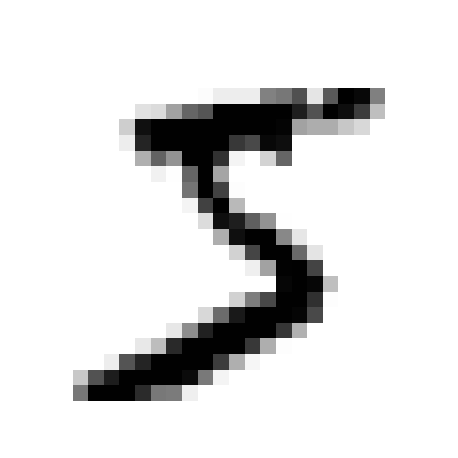

In [7]:
#import matplotlib as mpl
import matplotlib.pyplot as plt

# helper functie
# De functie neemt een array met beelddata (image_data) en herschikt deze naar een 2D-array van 28×2828×28 pixels, zoals gebruikelijk voor de MNIST-dataset.
# De plt.imshow-functie wordt gebruikt om het beeld in grijstinten weer te geven (cmap="binary").
# De assen worden uitgeschakeld met plt.axis("off") om de afbeelding schoon en overzichtelijk te houden.
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# X.values[0] selecteert de eerste rij uit de data (bijvoorbeeld de eerste handgeschreven cijferafbeelding).
some_digit = X.values[0]  # take first image
plot_digit(some_digit)
save_fig("some_digit_plot")  # save plot
plt.show()

In [8]:
# en volgens de dataset y hoort hier het label "5" bij
y[0]

'5'

Label is van (type)`string`. De meeste ML-algoritmen accepteren getallen, dus we converteren y naar getallen.

In [9]:
import numpy as np

y = y.astype(np.uint8)
y[0]

np.uint8(5)

### Oefening MNIST dataset - plot meerdere digits

Toon een aantal images van de MNIST dataset is een soort matrix, zoals bijvoorbeeld weergegeven in onderstaande figuren.

### Samples met labels
![sample_mnist](./images/sample_mnist.png)

### Samples zonder labels
![more_digits](./images/more_digits_plot.png)


In [10]:
# hier komt jouw code ...


Maak een trainings- en testset voordat je algoritmen toepast.

MNIST-dataset is zodanig opgesteld, dat het al opgesplitst is in een trainingsset (eerste 60.000 afbeeldingen) en een testset (de laatste 10.000 afbeeldingen).

De trainingsset is ook al geschud (*shuffled*), hetgeen goed is omdat het garandeerd dat alle *cross-validation folds* vergelijkbaar zijn.

In [11]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

### Trainen ML algorithm

Allereerst reduceren we het probleem tot classificeren van één digit, bijvoorbeeld getal "5". Deze "5-detector" is een voorbeeld van **binaire classifier**: het maakt onderscheidt tussen twee classen: "5" of "niet-5".

In [12]:
# create target vector for this classification task 
# Dus je maakt een vector van 60000 rijen met 1 kolom
y_train_5 = (y_train == 5)  # True for all 5-digits, False for other digits
# DEBUG print(y_train_5)
y_test_5 = (y_test == 5)
# DEBUG print(y_test)

We kiezen als *classifier* om te trainen de *Stochastic Gradient Descent* (SGD) classificatie. Deze classifier heeft het voordeel dat hij zeer grote datasets efficiënt kan verwerken.

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)  # train algorithm for "5"

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


SGDClassifier vertrouwt op willekeur tijdens de training (vandaar de naam "stochastic"). Als je reproduceerbare resultaten wilt, moet je de parameter `random_state` instellen.

In [14]:
# detect images of number "5"
# zie boven ... some_digit is de 28x28 representatie van een cijfer met label "5"
sgd_clf.predict([some_digit])

c:\Users\hq0132410\Downloads\Introduction-to-machine-learning\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

De uitvoer is een array met één element:

    [True] als het model denkt dat het cijfer "5" is.
    [False] anders.
    
En zoals je ziet is de uitkomst hierboven gelijk aan "TRUE" ...

Kortom het getrainde model sgd_clf is getained op alle 60000 afbeeldingen maar we hebben alleen getrained op "is het een cijfer 5 of niet"

Dus door een plaatje erin te gooien wat lijkt op het cijfer 5 blijkt er dus uit te komen TRUE = "ja volgens het model is dit het cijfer 5"